# Lesson 13.4 Dead ReLU Problem与学习率优化

&emsp;&emsp;和Sigmoid、tanh激活函数不同，ReLU激活函数的叠加并不会出现梯度消失或者梯度爆炸，但ReLU激活函数中使得部分数值归零的特性却会导致另外一个严重的问——Dead ReLU Problem，也被称为神经元活性失效问题。

## 一、Dead ReLU Problem成因分析

### 1.Dead ReLU Problem直接表现

&emsp;&emsp;首先我们通过实验来观察神经元活性失效问题（Dead ReLU Problem）在建模过程中的直接表现。

其实在上一节中，最后出现的ReLU叠加模型在迭代多次后在MSE取值高位收敛的情况，其实就是出现了神经元活性失效所导致的问题

In [4]:
# 设置随机数种子
torch.manual_seed(420)  

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w=[2, -1], bias=False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)


In [5]:
# 创建随机数种子
torch.manual_seed(420)  

# 实例化模型
relu_model3 = ReLU_class3(bias=False)              # 为了更方便的观察神经元活性失效问题，我们创建不带截距项的模型

# 核心参数
num_epochs = 20
lr = 0.03

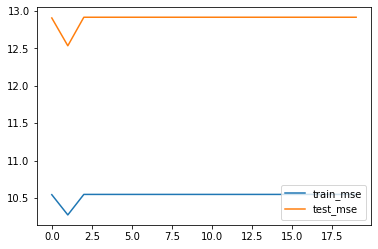

In [6]:
#————————————————————————————观察训练结果————————————————————————————

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = 0.03, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.legend(loc = 4)

#模型在迭代多轮之后，训练误差和测试误差都在各自取值的高位收敛了，
# 也就是误差不随模型迭代测试增加而递减。

In [7]:
relu_model3(features)

# 此时模型对所有数据的输出结果都是0

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

### 2.Dead ReLU Problem成因分析

#### 2.1 Dead ReLU Problem基本判别

&emsp;&emsp;神经元活性失效问题和ReLU激活函数本身特性有关。首先，我们观察ReLU激活函数函数图像与导函数图像。

In [28]:
# 绘制ReLU函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
X.requires_grad=True
relu_y = torch.relu(X)

In [29]:
# 反向传播
relu_y.sum().backward()

<AxesSubplot:>

Text(0.5, 1.0, 'ReLU Function')

<AxesSubplot:>

Text(0.5, 1.0, 'ReLU Derivative function')

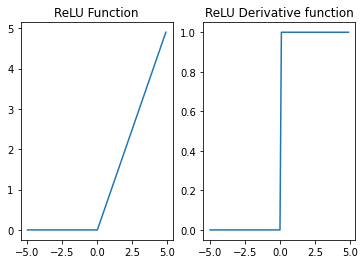

In [30]:
# ReLU函数图像
plt.subplot(121)
plt.plot(X.detach(), relu_y.detach())
plt.title("ReLU Function")

# ReLU导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title("ReLU Derivative function")

- ReLU激活函数:只要激活函数接收到的数据小于0，输出结果就全是0
-只要ReLU输出结果是0，由于ReLU的导函数是分段常数函数且接收数据为负时导数为0
- 因此如果ReLU输出结果为零，则反向传播结果、也就是各层的梯度，也都是零。

我们进一步通过举例说明，现在有模型基本结构如下

<img src="https://i.loli.net/2021/02/23/cld8x7RSXbhZDN2.jpg" alt="62" style="zoom:40%;" />

设w1为第一层传播的权重，w2为第二层传播的权重，f为输入的特征张量，并且只有一条数据

In [31]:
w1 = torch.tensor([[0., 0], [-1, -2]], requires_grad = True)
w1

# w1的第一列对应连接隐藏层第一个神经元的权重，0, -1
# w1的第二列对应连接隐藏层第二个神经元的权重，0,-2

tensor([[ 0.,  0.],
        [-1., -2.]], requires_grad=True)

In [32]:
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w2.requires_grad = True
w2

tensor([[ 1.],
        [-1.]], requires_grad=True)

In [33]:
# f为输入张量
f = torch.tensor([[1, 2.]])
f

tensor([[1., 2.]])

In [34]:
#————————————————————————————第一次向前传播————————————————————————————

# 线性变换
f2 = torch.mm(f,w1)
f2

# 激活函数处理
f3 = torch.relu(f2)
f3

# 输出结果
# 矩阵乘法区分左 右
out = torch.mm(f3,w2)
out

# 模型预测结果为0

tensor([[-2., -4.]], grad_fn=<MmBackward0>)

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

tensor([[0.]], grad_fn=<MmBackward0>)

In [35]:
#————————————————————————————损失函数和反向传播过程————————————————————————————

# l为f的真实标签
l = torch.tensor([[3.]])
l

loss = F.mse_loss(out,l)
loss


tensor([[3.]])

tensor(9., grad_fn=<MseLossBackward0>)

In [36]:
loss.backward()


In [37]:
w1.grad
w2.grad

# 模型预测结果为0时，模型参数的梯度也为0 
# 无法实现梯度下降的更新

tensor([[0., 0.],
        [0., 0.]])

tensor([[0.],
        [0.]])

->当某条数据在模型中的输出结果为0时  
->反向传播后各层参数的梯度也全为0   
-> 参数无法得到更新  
-> 模型失效Dead ReLU Problem  

当然，上述过程可以由如下数学过程说明，假设模型预测值:$$\hat y = ReLU(X * w_1) * w_2$$

并且，出现Dead ReLU Problem的时候，某一组$w_1$恰好使得ReLU输出结果为0，因此$\hat y = 0$，而此时损失函数为：

$$loss = MSE = \frac{\sum ((\hat y - y) ^ 2)}{N} $$

根据链式法则，此时梯度为：
$$
\begin{aligned}
grad &= ( \frac{\partial loss}{\partial w_1}, \frac{\partial loss}{\partial w_2}) \\
&= (\frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_1}, \frac{\partial loss}{\partial \hat y} \frac{\partial \hat y}{\partial w_2})\\
\end{aligned}
$$

由于$\hat y$恒为0（为一个常量），由ReLU激活函数导函数特性可知，$\hat y$对任何自变量偏导也为0.

此时grad也就为0，$w_1、w_2$不会再更新。而参数不更新，$\hat y$仍然为0，梯度还是为0，如此往复，就出现了上述死循环，也就是Dead ReLU Problem。

#### 2.2 Dead ReLU Problem发生概率

出现Dead ReLU Problem问题的概率伴随ReLU层的增加而增加的。如果是两层ReLU层，模型结构如下：

<center><img src="https://i.loli.net/2021/02/24/9g1tykm8djrPKQN.jpg" alt="63" style="zoom:35%;" />

向前传播过程中，模型输出结果为：

$$\hat y = ReLU(ReLU(X * w_1) * w_2) * w_3$$

不难发现，在两层ReLU嵌套的情况下，$\hat y$取值为0的概率就更大了，出现Dead ReLU Problem的概率也就更高了。而同时，根据各层参数的梯度计算公式我们也能够发现，只要其中任意一层输出结果是0，则所有层参数的梯度均为0。

$$
grad_1 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
w_2 \cdot f(X * w_1) \cdot X 
$$

$$
grad_2 
= \frac{\partial loss}{\partial \hat y} 
\cdot 
w_3 \cdot f(F(X*w_1)*w_2) \cdot
F(X * w_1) 
$$

$$
grad_3 = \frac{\partial loss}{\partial \hat y} 
\cdot 
F(F(X * w_1) * w_2)
$$

最终，我们可以通过如下表达式判别ReLU激活函数是否失效

In [38]:
train_loader.dataset[:][0]
# 训练集的特征

tensor([[-1.4463, -0.6221],
        [-0.4742, -0.2939],
        [ 1.9870,  0.1949],
        ...,
        [-1.6366, -2.1399],
        [-1.8178, -1.4618],
        [ 0.2646,  2.3555]])

In [39]:
# 带入数据进行训练
relu_model3(train_loader.dataset[:][0])

# 预测结果均为0，模型失效

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [40]:
(relu_model3(train_loader.dataset[:][0]) == 0).sum()

# 所有结果都0

tensor(700)

## 二、通过调整学习率缓解Dead ReLU Problem

所有的解决Dead ReLU Problem的方法中，最简单的一种方法就是调整学习率。

对于ReLU激活函数来说，参数容易落入输出值全为0的陷阱，因此训练过程需要更加保守，采用更小的学习率逐步迭代。

当然学习率减少就必然需要增加迭代次数，但由于ReLU激活函数计算过程相对简单，增加迭代次数并不会显著增加计算量。  


Text(0.5, 1.0, 'lr=0.03')

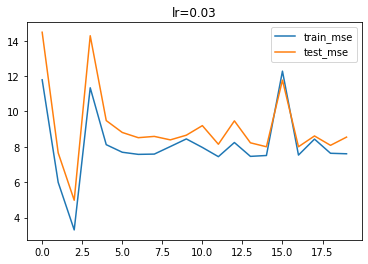

In [41]:
# 设置随机数种子
torch.manual_seed(420)  

# 核心参数
num_epochs = 20
lr = 0.03

# 实例化模型
relu_model3 = ReLU_class3()

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.title('lr=0.03')
plt.legend(loc = 1)


# 模型在的MSE在高位收敛

Text(0.5, 1.0, 'lr=0.001')

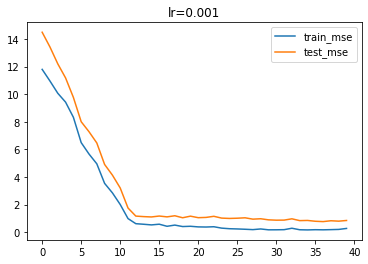

In [42]:
#————————————————————————————调小学习率————————————————————————————
# 设置随机数种子
torch.manual_seed(420)  

# 核心参数
num_epochs = 40
lr = 0.001

# 实例化模型
relu_model3 = ReLU_class3()

# 模型训练
train_l, test_l = model_train_test(relu_model3, 
                                   train_loader,
                                   test_loader,
                                   num_epochs = num_epochs, 
                                   criterion = nn.MSELoss(), 
                                   optimizer = optim.SGD, 
                                   lr = lr, 
                                   cla = False, 
                                   eva = mse_cal)



# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_l, label='train_mse')
plt.plot(list(range(num_epochs)), test_l, label='test_mse')
plt.title('lr=0.001')
plt.legend(loc = 1)

# 调小学习率，模型的效果更好

## 三、ReLU激活函数特性理解


从梯度消失和梯度爆炸角度考虑，ReLU激活函数拥有更加优异的特性。我们都知道，ReLU激活函数的导函数取值要么是1要么是0，当导函数取值为1时，能够保证各层参数的梯度在计算时不受因层数变化而累乘的导函数影响（因为导函数取值都为1）。

In [43]:
# 观察各层梯度
for m in relu_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-7.3739, -2.6226],
        [-7.9173, -2.6964],
        [ 3.7016,  0.4324],
        [ 9.1712,  5.0160]])
tensor([[  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [-10.6886,  -5.4182,  -1.6595, -15.9431],
        [  4.7269,   2.3813,   0.8299,   6.8923]])
tensor([[ 0.0000,  0.0000,  2.6702,  1.5113],
        [ 0.0000,  0.0000,  2.9438,  1.6662],
        [ 0.0000,  0.0000, -3.1529, -1.7845],
        [ 0.0000,  0.0000, -3.0916, -1.7498]])
tensor([[-0.7726, -1.0440, -2.4470, -2.2477]])


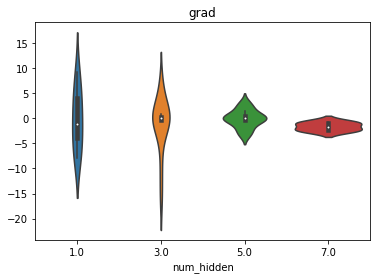

In [44]:
weights_vp(relu_model3, att="grad")

能够看出，模型各层仍然处在学习状态，虽然存在梯度不均的状态，但在学习率非常小的情况下整体表现仍然较为平稳。

不过需要注意的是，对于ReLU激活函数来说，每一层梯度分布的小提琴图会很大程度受到梯度0值的影响，并且每一次迭代完成后是否取0值都会发生变化，从而影响小提琴图对真实情况反应的准确程度。

## 四、nn.Sequential快速建模方法及nn.init模型参数自定义方法

- 使用`nn.Sequential`进行模型的快速构建
- 使用`nn.init`来进行模型参数修改

### 1.nn.Sequential快速建模方法介绍

PyTorch还支持使用nn.Sequential来快速，在借助nn.Sequential进行模型构建过程中，我们只需要将每一层神经元连接方法和激活函数作为参数输入nn.Sequential即可。
- nn.Sequential(nn.Linear(),nn.ReLU(),nn.Linear(),...)
- 仅适用于建立线性叠加模型，有一定的局限性

In [47]:
# 设置随机数种子
torch.manual_seed(25)


# 构建上述LR_ReLU_test模型
# relu_test相当于已经实例化之后的模型
relu_test = nn.Sequential(nn.Linear(2,2,bias=False),nn.ReLU(),nn.Linear(2,1,bias=False))
# INput-> 线性层->激活函数 -> 线性层 -> out

In [48]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

而此时的实例化，是nn.Sequential类的实例化，也就是说，通过nn.Sequential创建的模型本质上都是nn.Sequential的一个实例。

In [49]:
isinstance(relu_test, nn.Sequential)

True

In [50]:
# 而此前创建的模型都是我们所创建的类的实例
isinstance(relu_model3, ReLU_class3)

True

而上述`nn.Sequential`所创建的模型结构，就相当于是两层全连接神经网络，并且隐藏层使用ReLU进行处理。其中需要注意的是，nn.ReLU()单独使用时就相当于ReLU函数，而放在nn.Sequential中就等价于对某一层的输出结果进行ReLU处理。

In [51]:
r1 = nn.ReLU()

In [52]:
t = torch.tensor([1., -1])
t

tensor([ 1., -1.])

In [53]:
r1(t)

tensor([1., 0.])

In [54]:
torch.relu(t)

tensor([1., 0.])

当然，通过nn.Sequential定义的模型也可以执行向前传播过程

In [55]:
f = torch.tensor([[1, 2.]], requires_grad = True)
f

relu_test.forward(f)

tensor([[1., 2.]], requires_grad=True)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

In [58]:
#————————————————————————————手动验证————————————————————————————
w1 = list(relu_test.parameters())[0].t()         # 第一层传播参数
w1

w2 = list(relu_test.parameters())[1].t()         # 第二层传播参数
w2

torch.mm(torch.relu(torch.mm(f, w1)), w2)

tensor([[ 0.3561, -0.6182],
        [-0.4343,  0.5823]], grad_fn=<TBackward0>)

tensor([[-0.1658],
        [-0.2843]], grad_fn=<TBackward0>)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

利用nn.Sequential进行模型创建在模型结构相对简单时可以大幅减少代码量，并且模型效果和先通过定义类、再进行实例化的模型效果相同。

但该方法在定义高度复杂的模型、或者定义更加灵活的模型时就显得力不从心了。因此，对于新手，推荐先掌握利用类定义模型的方法，再掌握利用nn.Sequential定义模型的方法。

### 2.模型参数自定义方法

首先，对于模型参数来说，parameters返回结果是个生成器（generator），通过list转化后会生成一个由可微张量构成的list。

- 通过修改可微张量方法修改参数

In [61]:
relu_test.parameters()

list(relu_test.parameters())

list(relu_test.parameters())[0]

<generator object Module.parameters at 0x00000195681B8C80>

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

- 使用.data的方法对其进行修改

In [64]:
#————————————————————————————.data方法修改参数————————————————————————————

# 修改目标
w1 = torch.tensor([[0., 0], [-1, -2]])
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w1
w2

list(relu_test.parameters())[0].data = w1.t()
list(relu_test.parameters())[1].data = w2.t()

# 查看修改结果
list(relu_test.parameters())

tensor([[ 0.,  0.],
        [-1., -2.]])

tensor([[ 1.],
        [-1.]])

[Parameter containing:
 tensor([[ 0., -1.],
         [ 0., -2.]], requires_grad=True),
 Parameter containing:
 tensor([[ 1., -1.]], requires_grad=True)]

- 使用init方法创建满足某种分布的参数
  - `nn.init.uniform_(list(模型.参数())[0],mean,std`)方法，新生成的参数服从均匀分布
    - 带_的表示直接修改对象本身
  - `nn.init.normal_(list(模型.参数())[0], 0, 1)`        
    -  服从均值为0、标准差为1的正态分布
  - `nn.init.constant_(tensor类型, n)` 利用常数填充

In [65]:
# ————————重新设置初始化模型参数取值————————
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2, 2, bias=False), nn.ReLU(), nn.Linear(2, 1, bias=False))

In [66]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

(1).nn.init.uniform_方法，新生成的参数服从均匀分布

In [67]:
nn.init.uniform_(relu_test.parameters(), 0, 1)   

# 作用的对象是张量，不能直接输入模型的参数生成器

AttributeError: 'generator' object has no attribute 'uniform_'

In [68]:
list(relu_test.parameters())[0]

# 提取第一个张量

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

In [69]:
nn.init.uniform_(list(relu_test.parameters())[0], 0, 1)       
 # 设置参数值为均匀分布在0，1区间内的随机数

Parameter containing:
tensor([[0.5933, 0.2911],
        [0.2416, 0.5582]], requires_grad=True)

(2)`.nn.init.normal_方法`，新生成的参数服从正态分布

In [70]:
nn.init.normal_(list(relu_test.parameters())[0], 0, 1)        
# 服从均值为0、标准差为1的正态分布

# 就相当于手动修改，

Parameter containing:
tensor([[-1.3812,  1.2157],
        [ 0.0827,  0.5799]], requires_grad=True)

In [71]:
#使用size参数，最后需要令其可导并替换原始参数值
torch.normal(0, 1, size = list(relu_test.parameters())[0].size())

tensor([[ 0.0578, -0.2979],
        [-1.2089, -0.0560]])

(3).nn.init.constant_方法，新生成的参数值为某一常数

In [72]:
nn.init.constant_(list(relu_test.parameters())[0], 1)        # 参数全为1

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)